In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import stateinterpreter
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import Classifier
from stateinterpreter.plot import plot_cvpath, plot_states
from importlib import reload
from matplotlib.ticker import MaxNLocator
reload(stateinterpreter.MD)
reload(stateinterpreter.classifier)
reload(stateinterpreter.plot)

<module 'stateinterpreter.plot' from '../../stateinterpreter/plot.py'>

In [2]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
# Compute descriptors from Trajectory
data = Loader(colvar_file, kbt=2.8, stride=100)
data.load_trajectory(traj_dict)

Collective variables: (5248, 9)
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (5248, 783)


In [3]:
cv_list = ['deep.node-4', 'deep.node-3']
data.identify_states(cv_list, bw_method=0.07, memory_saver=True)

DEV >>> Approximating FES
DEV >>> Finding Local Minima


100%|██████████| 50/50 [00:00<00:00, 1080.34it/s]

DEV >>> Basin Assignment


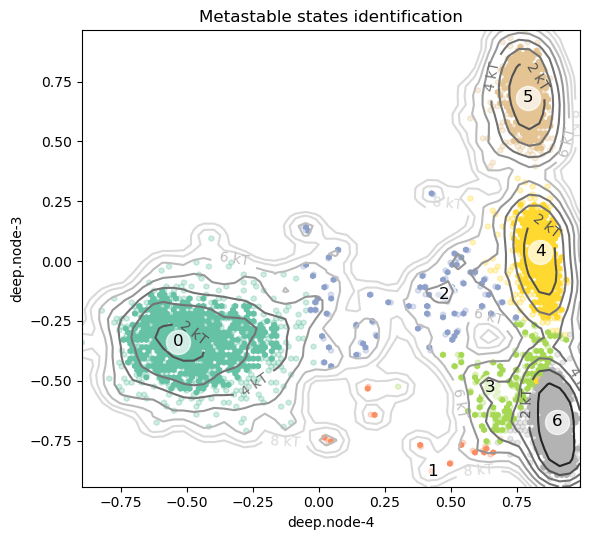

In [4]:
plot_states(data, fes_isolines=True)

In [6]:
descriptors = data.collect_data()

In [8]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'sin_|cos_'
sample = data.sample(100, regex_filter = select_feat, states_subset=[4, 5, 6])
classifier = Classifier(sample)
classifier.compute(regularizers, max_iter= 10000)

State 4:
	 100.0%  | BACKBONE cos_phi PRO4
State 5:
	 52.119% | SIDECHAIN cos_chi1 THR8
	 47.881% | SIDECHAIN sin_chi1 THR6
State 6:
	 64.962% | SIDECHAIN sin_chi1 THR6
	 32.106% | SIDECHAIN cos_chi1 THR8
	 1.268%  | BACKBONE cos_psi THR8
	 0.969%  | SIDECHAIN sin_chi1 THR8
	 0.695%  | BACKBONE cos_phi GLY7


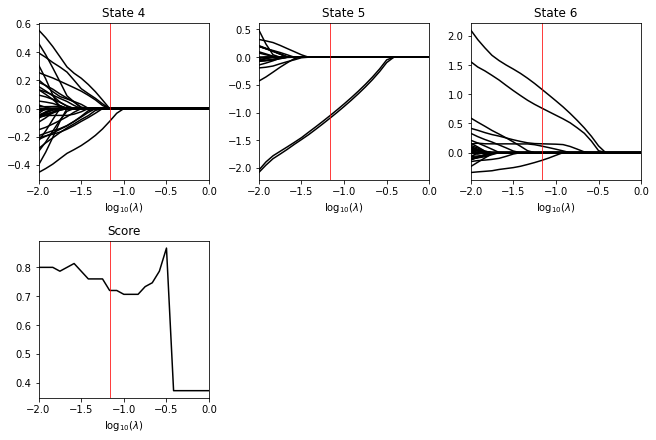

In [9]:
reg = 10**(-1.2)
plot_cvpath(classifier, reg);
classifier.print_selected(reg)

In [7]:
import re
def get_residue(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

def _get_angle_groups(angle_names):
    groups = []
    for s in angle_names:
        groups.append(get_residue(s))
    return np.array(groups, dtype=int)


In [8]:
groups = _get_angle_groups(sample.features)
regularizers = np.geomspace(0.01, 1, 25)
dset = sample.train_test_dataset()
classifier = Classifier(dset, sample.features)
classifier.compute(regularizers, max_iter= 100, groups=groups)

/home/novelli/anaconda3/lib/python3.8/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/home/novelli/anaconda3/lib/python3.8/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/home/novelli/anaconda3/lib/python3.8/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/home/novelli/anaconda3/lib/python3.8/site-packages/group_lasso/_fista.py:114: ConvergenceW

State 1:
	 62.57%  | 6
	 37.43%  | 8
State 2:
	 54.901% | 6
	 45.099% | 8
State 3:
	 56.406% | 6
	 43.594% | 8


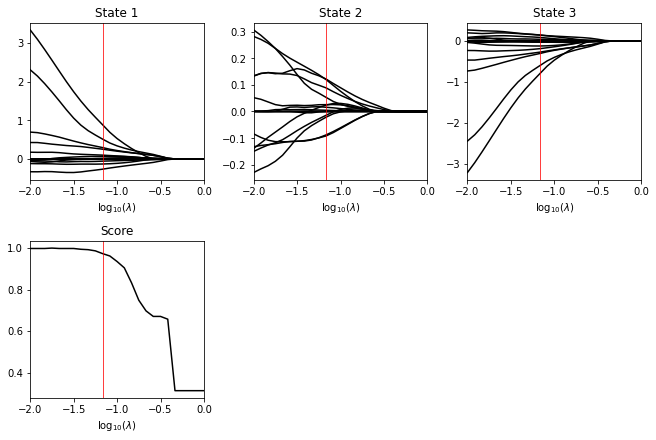

In [10]:
reg = 10**(-1.2)
plot_cvpath(classifier, reg);
classifier.print_selected(reg)

In [12]:
num_groups = []
for reg in regularizers:
    selected = classifier._get_selected(reg)
    unique_idxs = set()
    for state in selected:
        for data in state:
            unique_idxs.add(data[0])
    num_groups.append(len(unique_idxs))


(-2.0, 0.0)

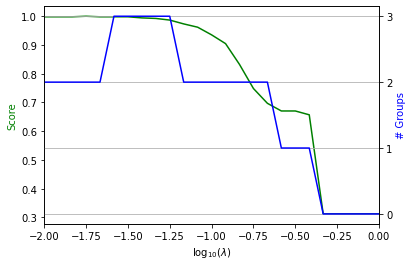

In [14]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.grid()
ax2.plot(np.log10(regularizers), num_groups, 'b-')
ax1.plot(np.log10(regularizers), classifier._crossval, 'g-')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel(r"$\log_{10}(\lambda)$")
ax1.set_ylabel('Score', color='g')
ax2.set_ylabel('# Groups', color='b')
ax1.set_xlim(np.log10(regularizers)[0],np.log10(regularizers)[-1])


A note on the problem to solve:
1. For regular Lasso $$ \min_{w}C\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \Vert w \Vert_{1}$$
2. For _group_ Lasso $$ \min_{w} \frac{1}{n}\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \lambda \sum_{j}  \Vert w_{j} \Vert_{2}$$

To have everything consistent $C \mapsto (\lambda n)^{-1}$. I'll use $\lambda$ as regularization parameter.